### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline
from sklearn.model_selection import HalvingRandomSearchCV
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from joblib import parallel_backend
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score

# <h1 style="text-align: center"> <b> Exploration des données</b><br></h1>

### Chargement des données

In [ ]:
root = "inf-8245-e-fall-2024"
train = pd.read_csv(f"{root}/train.csv", index_col=0)
labels = pd.read_csv(f"{root}/labels.csv", index_col=0)
data = train.join(labels)
#Suppression des données catégorielles
sup_col = ["Age_Group", "BMI_Category", "Education_Level", "Income_Group"]
data = data.drop(columns=sup_col)
data.head()

HighBP  HighChol  CholCheck        BMI  Smoker  Stroke  \
31141        0         1          1  20.693674       1       0   
98230        0         0          1  28.375985       0       0   
89662        1         1          1  24.629353       0       0   
208255       0         1          1  27.246610       0       0   
233415       0         1          1  23.671678       0       0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  PhysHlth  \
31141                      0             1       1        1  ...  0.576910   
98230                      0             1       0        1  ... -0.051198   
89662                      0             1       1        1  ...  5.066202   
208255                     0             1       1        1  ... -0.277887   
233415                     0             1       1        1  ... -0.212703   

        DiffWalk  Sex        Age  Education  Income  Healthy_Diet  \
31141          0    1  11.725312        6.0     8.0             1   
98230          0    1   7.977719        5.0     8.0             0   
89662          0    1   8.161838        5.0     6.0             1   
208255         0    1   5.038298        6.0     7.0             1   
233415         1    0  12.037360        4.0     6.0             1   

        Mental_Health_Risk  Heart_Disease_Risk  Diabetes_binary  
31141                    0                   2                0  
98230                    0                   0                0  
89662                    0                   2                1  
208255                   0                   1                0  
233415                   0                   1                0  

[5 rows x 25 columns]

### Analyse

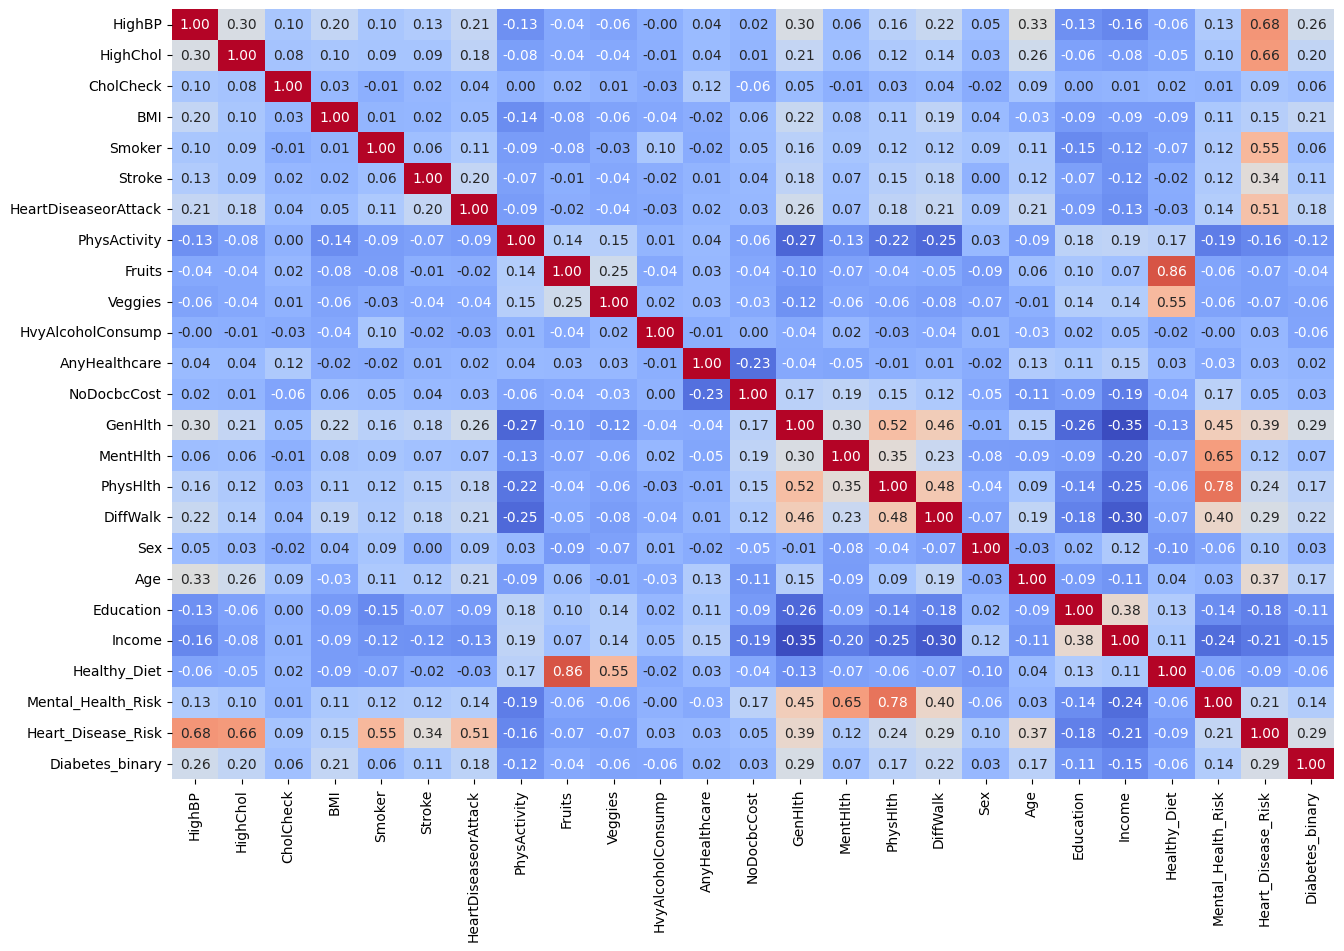

In [ ]:
#Correlation
corr = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
plt.show()


In [ ]:
#Check pour les doublons
doublons = data.duplicated()
print(doublons.sum())

#Suppression des doublons
data = data.drop_duplicates()
data.shape

0


(202944, 25)

### Aperçu des données

In [ ]:
print("Forme des données :", data.shape)
print("\nColonnes :")
print(data.columns)
print("\nInformations sur les données :")
print(data.info())
print("\nRésumé statistique :")
print(data.describe())

Forme des données : (202944, 25)

Colonnes :
Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Healthy_Diet', 'Mental_Health_Risk', 'Heart_Disease_Risk',
       'Diabetes_binary'],
      dtype='object')

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
Index: 202944 entries, 31141 to 121958
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                202944 non-null  int64  
 1   HighChol              202944 non-null  int64  
 2   CholCheck             202944 non-null  int64  
 3   BMI                   202944 non-null  float64
 4   Smoker                202944 non-null  int64  
 5   Stroke                202944 non-null  i

### Moyenne pour les cas diabétiques ou non

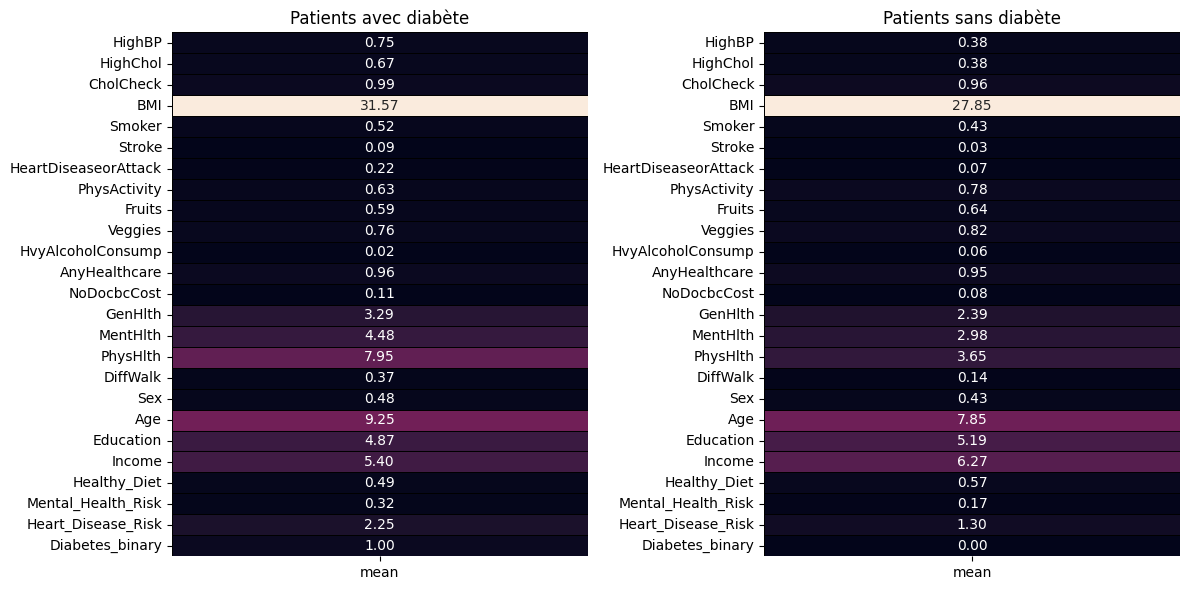

In [ ]:
#Recupère les cas de diabète/négatif
diabetes = data[data['Diabetes_binary'] == 1].describe().T
non_diabetes = data[data['Diabetes_binary'] == 0].describe().T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

#Moyennes pour les patients avec diabète
plt.subplot(1, 2, 1)
sns.heatmap(diabetes[['mean']], annot=True, linewidths=0.4, linecolor='black', cbar=False, fmt='.2f')
plt.title('Patients avec diabète')

#Moyennes pour les patients sans diabète
plt.subplot(1, 2, 2)
sns.heatmap(non_diabetes[['mean']], annot=True, linewidths=0.4, linecolor='black', cbar=False, fmt='.2f')
plt.title('Patients sans diabète')
fig.tight_layout()
plt.show()

### Analyse des distributions

In [ ]:
#Separation des features numeriques et categoriques
numerical_features = data.select_dtypes(include=["int64", "float64"]).columns.tolist()

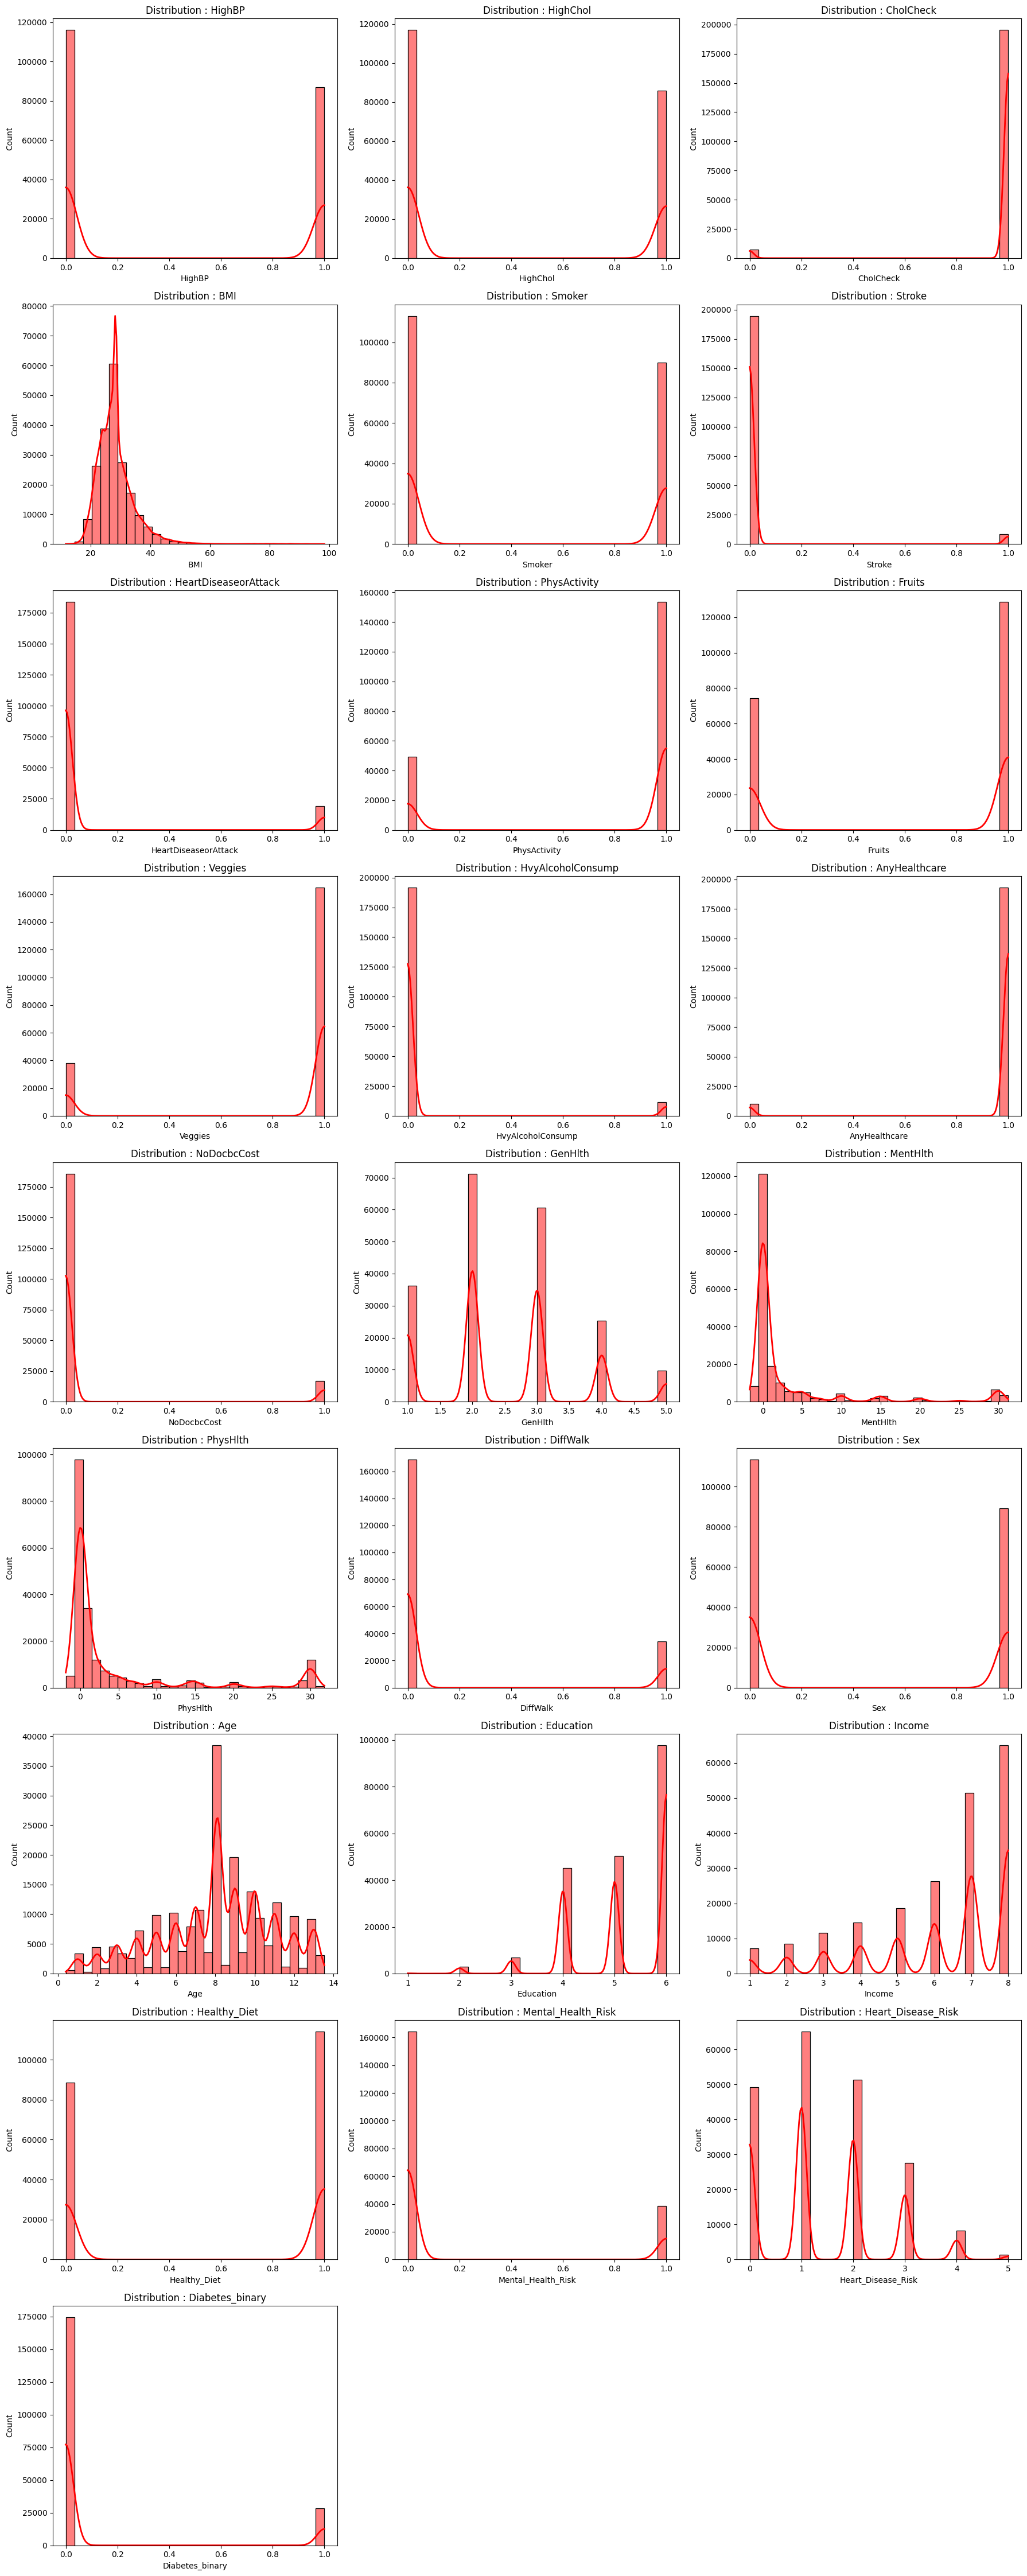

In [ ]:

n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes]

for i, column in enumerate(numerical_features):
    sns.histplot(
        data[column],
        kde=True,
        color="red",
        bins=30,
        line_kws={"linewidth": 2},
        ax=axes[i]
    )
    axes[i].set_title(f"Distribution : {column}", fontsize=12)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")

# Supprimer les graphiques vides si le nombre de colonnes n'est pas divisible par n_cols
for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Analyse de chaque features

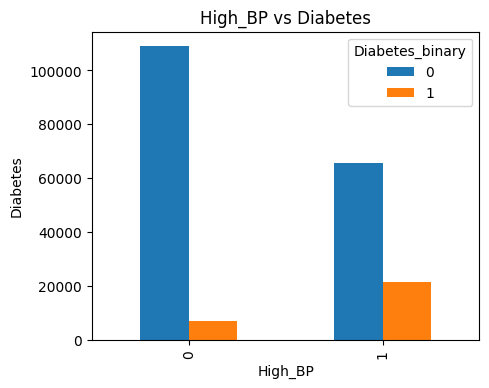

In [ ]:
#Analyse du lien entre High_BP et Diabetes
(data.groupby("Diabetes_binary")["HighBP"].value_counts()/data.groupby("Diabetes_binary")["HighBP"].count())*100

pd.crosstab(data['HighBP'], data['Diabetes_binary']).plot(kind="bar",figsize=(5,4))
plt.title('High_BP vs Diabetes')
plt.xlabel('High_BP')
plt.ylabel('Diabetes')
plt.show()

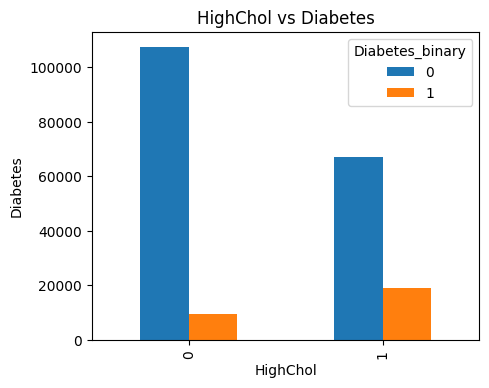

In [ ]:
(data.groupby("Diabetes_binary")["HighChol"].value_counts()/data.groupby("Diabetes_binary")["HighChol"].count())*100
#Analyse du lien entre HighChol et Diabetes
pd.crosstab(data['HighChol'], data['Diabetes_binary']).plot(kind="bar",figsize=(5,4))
plt.title('HighChol vs Diabetes')
plt.xlabel('HighChol')
plt.ylabel('Diabetes')
plt.show()

Text(0.5, 1.0, 'Relation b/w HighBP ,HighChol and Diabetes')

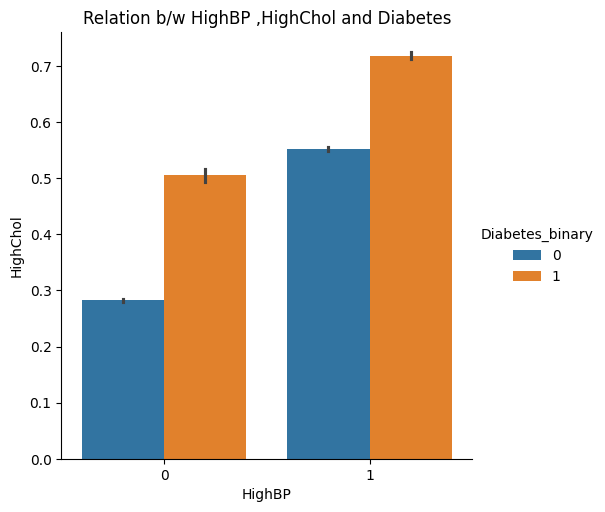

In [ ]:
#Combinaison de HighBP et HighChol
(data.groupby(["HighBP" , "HighChol"])["Diabetes_binary"].value_counts()/data.groupby(["HighBP" , "HighChol"])["Diabetes_binary"].count())*100
sns.catplot(x="HighBP" , y ="HighChol" , data=data , hue="Diabetes_binary" , kind="bar" )
plt.title("Relation b/w HighBP ,HighChol and Diabetes")

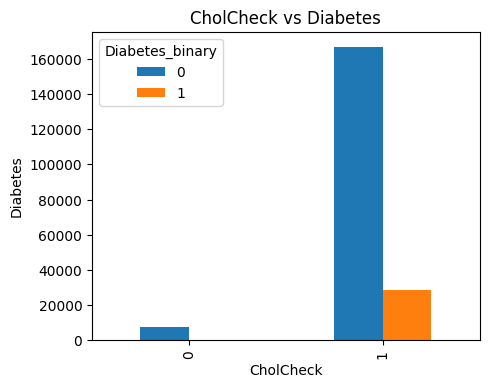

In [ ]:
data.groupby("CholCheck")["Diabetes_binary"].value_counts()/data.groupby("CholCheck")["Diabetes_binary"].count()*100
#Analyse entre CholCheck et Diabetes
pd.crosstab(data['CholCheck'], data['Diabetes_binary']).plot(kind="bar",figsize=(5,4))
plt.title('CholCheck vs Diabetes')
plt.xlabel('CholCheck')
plt.ylabel('Diabetes')
plt.show()

Text(0.5, 1.0, 'Relation b/w CholCheck ,HighChol and Diabetes')

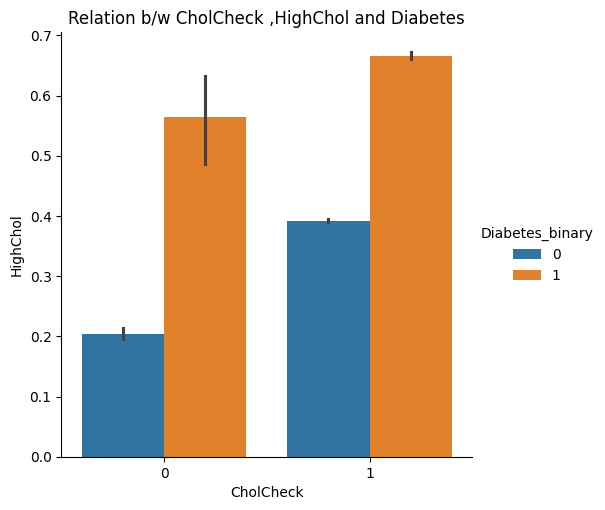

In [ ]:
#Relier CholCheck et HighChol pour voir si les deux sont liés
(data.groupby(["CholCheck" , "HighChol"])["Diabetes_binary"].value_counts()/data.groupby(["CholCheck" , "HighChol"])["Diabetes_binary"].count())*100
sns.catplot(x="CholCheck" , y ="HighChol" , data=data , hue="Diabetes_binary" , kind="bar" )
plt.title("Relation b/w CholCheck ,HighChol and Diabetes")

In [ ]:
#Divise les BMI en 3 categories
data['BMI_Category'] = pd.cut(data['BMI'], bins=[0, 24.9, 29.9, 34.9, 39.9, 100], labels=['Normal', 'Overweight', 'Obese-1', 'Obese-2', 'Obese-3'])
#Correlation des differentes catégories de BMI par rapport au diabète
(data.groupby("BMI_Category")["Diabetes_binary"].value_counts()/data.groupby("BMI_Category")["Diabetes_binary"].count())*100

C:\Users\cleme\AppData\Local\Temp\ipykernel_4088\3952009002.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (data.groupby("BMI_Category")["Diabetes_binary"].value_counts()/data.groupby("BMI_Category")["Diabetes_binary"].count())*100
C:\Users\cleme\AppData\Local\Temp\ipykernel_4088\3952009002.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (data.groupby("BMI_Category")["Diabetes_binary"].value_counts()/data.groupby("BMI_Category")["Diabetes_binary"].count())*100


BMI_Category  Diabetes_binary
Normal        0                  93.988782
              1                   6.011218
Overweight    0                  87.624625
              1                  12.375375
Obese-1       0                  79.997206
              1                  20.002794
Obese-2       0                  72.415275
              1                  27.584725
Obese-3       0                  66.089216
              1                  33.910784
dtype: float64

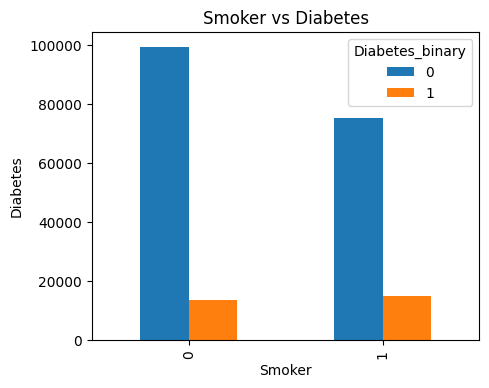

In [ ]:
#Impact de fumer sur le diabète
(data.groupby("Smoker")["Diabetes_binary"].value_counts()/data.groupby("Smoker")["Diabetes_binary"].count())*100
pd.crosstab(data['Smoker'], data['Diabetes_binary']).plot(kind="bar",figsize=(5,4))
plt.title('Smoker vs Diabetes')
plt.xlabel('Smoker')
plt.ylabel('Diabetes')
plt.show()

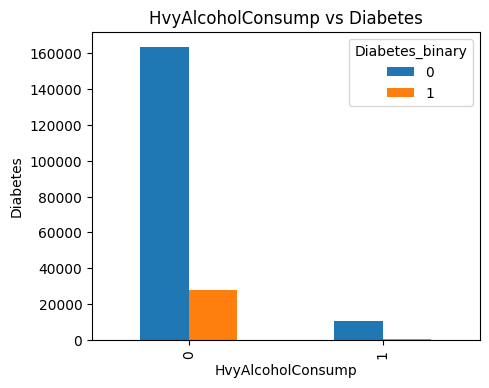

In [ ]:
#Impact de l'alcool sur le diabète
(data.groupby("HvyAlcoholConsump")["Diabetes_binary"].value_counts()/data.groupby("HvyAlcoholConsump")["Diabetes_binary"].count())*100
pd.crosstab(data['HvyAlcoholConsump'], data['Diabetes_binary']).plot(kind="bar",figsize=(5,4))
plt.title('HvyAlcoholConsump vs Diabetes')
plt.xlabel('HvyAlcoholConsump')
plt.ylabel('Diabetes')
plt.show()

Text(0.5, 1.0, 'Relation b/w Smoker ,HvyAlcoholConsump and Diabetes')

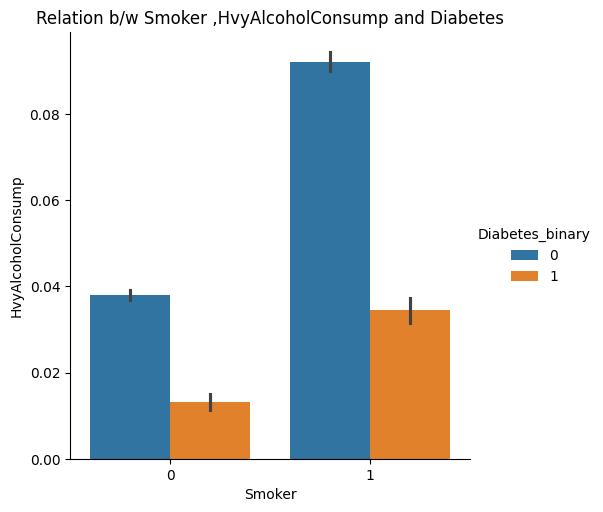

In [ ]:
#Combinaison de fumer et alcool
data.groupby(["Smoker" , "HvyAlcoholConsump"])["Diabetes_binary"].value_counts()/data.groupby(["Smoker" , "HvyAlcoholConsump"])["Diabetes_binary"].count()
sns.catplot(x="Smoker" , y ="HvyAlcoholConsump" , data = data , hue="Diabetes_binary"  , kind="bar"  );
plt.title("Relation b/w Smoker ,HvyAlcoholConsump and Diabetes")

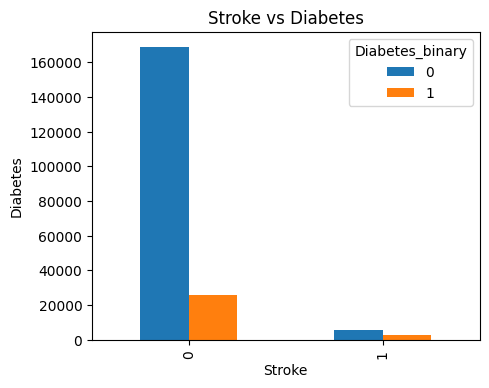

In [ ]:
#Stroke et diabète
data.groupby("Stroke")["Diabetes_binary"].value_counts()/data.groupby("Stroke")["Diabetes_binary"].count()
pd.crosstab(data['Stroke'], data['Diabetes_binary']).plot(kind="bar",figsize=(5,4))
plt.title('Stroke vs Diabetes')
plt.xlabel('Stroke')
plt.ylabel('Diabetes')
plt.show()

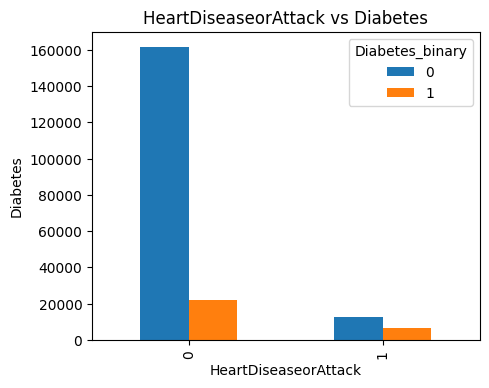

In [ ]:
#Heart Disease et diabète
data.groupby("HeartDiseaseorAttack")["Diabetes_binary"].value_counts()/data.groupby("HeartDiseaseorAttack")["Diabetes_binary"].count()
pd.crosstab(data['HeartDiseaseorAttack'], data['Diabetes_binary']).plot(kind="bar",figsize=(5,4))
plt.title('HeartDiseaseorAttack vs Diabetes')
plt.xlabel('HeartDiseaseorAttack')
plt.ylabel('Diabetes')
plt.show()

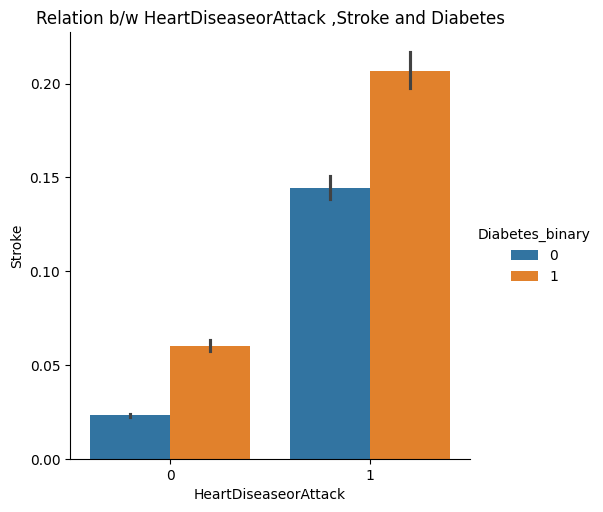

In [ ]:
#Fusion de HeartDiseaseorAttack et Stroke
data.groupby(["HeartDiseaseorAttack" , "Stroke"])["Diabetes_binary"].value_counts()/data.groupby(["HeartDiseaseorAttack" , "Stroke"])["Diabetes_binary"].count()
sns.catplot(x="HeartDiseaseorAttack" , y ="Stroke" , data = data , hue="Diabetes_binary"  , kind="bar"  )
plt.title("Relation b/w HeartDiseaseorAttack ,Stroke and Diabetes")
plt.xlabel('HeartDiseaseorAttack')
plt.ylabel('Stroke')
plt.show()

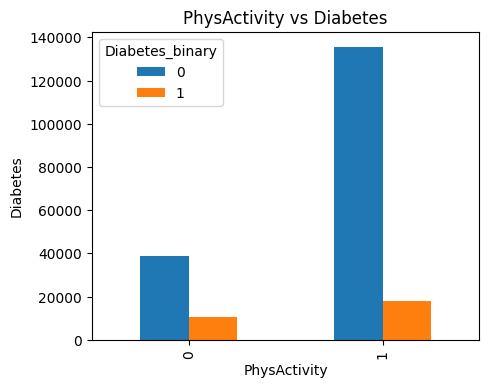

In [ ]:
#Activité physique et diabète
data.groupby("PhysActivity")["Diabetes_binary"].value_counts()/data.groupby("PhysActivity")["Diabetes_binary"].count()
pd.crosstab(data['PhysActivity'], data['Diabetes_binary']).plot(kind="bar",figsize=(5,4))
plt.title('PhysActivity vs Diabetes')
plt.xlabel('PhysActivity')
plt.ylabel('Diabetes')
plt.show()

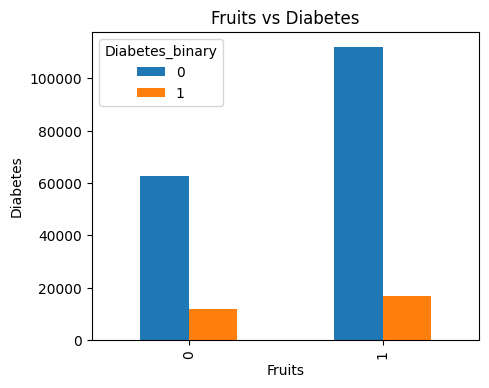

In [ ]:
#Lien Fruits et diabète
data.groupby("Fruits")["Diabetes_binary"].value_counts()/data.groupby("Fruits")["Diabetes_binary"].count()
pd.crosstab(data['Fruits'], data['Diabetes_binary']).plot(kind="bar",figsize=(5,4))
plt.title('Fruits vs Diabetes')
plt.xlabel('Fruits')
plt.ylabel('Diabetes')
plt.show()

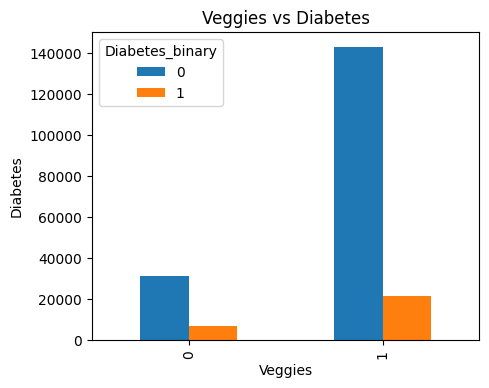

In [ ]:
#Lien Légumes et diabète
data.groupby("Veggies")["Diabetes_binary"].value_counts()/data.groupby("Veggies")["Diabetes_binary"].count()
pd.crosstab(data['Veggies'], data['Diabetes_binary']).plot(kind="bar",figsize=(5,4))
plt.title('Veggies vs Diabetes')
plt.xlabel('Veggies')
plt.ylabel('Diabetes')
plt.show()

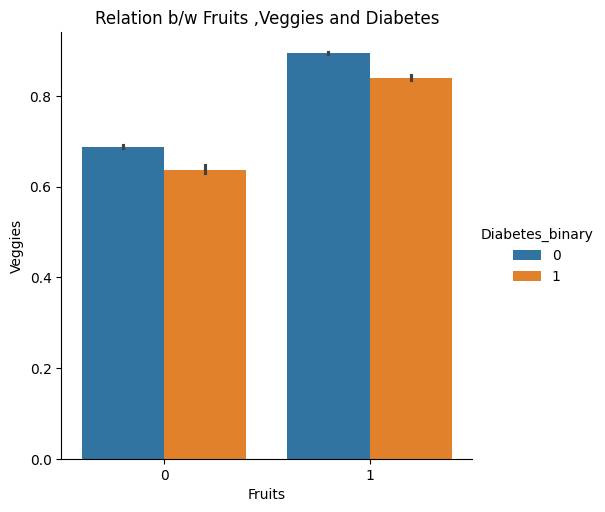

In [ ]:
#Combinaison de Fruits et Légumes lien diabète
(data.groupby(["Fruits" , "Veggies"])["Diabetes_binary"].value_counts()/data.groupby(["Fruits" , "Veggies"])["Diabetes_binary"].count())*100
sns.catplot(x="Fruits" , y ="Veggies" , data = data , hue="Diabetes_binary"  , kind="bar"  )
plt.title("Relation b/w Fruits ,Veggies and Diabetes")
plt.xlabel('Fruits')
plt.ylabel('Veggies')
plt.show()

In [ ]:
#Verif si healthy_diet est une combinaison de fruits et légumes
data['HealthyDiet_Check'] = (data['Veggies'] & data['Fruits']).astype(int)

difference = (data['Healthy_Diet'] != data['HealthyDiet_Check']).sum()
if difference == 0:
    print("Combinaison")
else:
    print("Pas une combinaison")

Combinaison


La colonne 'HealthyDiet' correspond exactement à la combinaison logique de 'Veggies' et 'Fruits'.

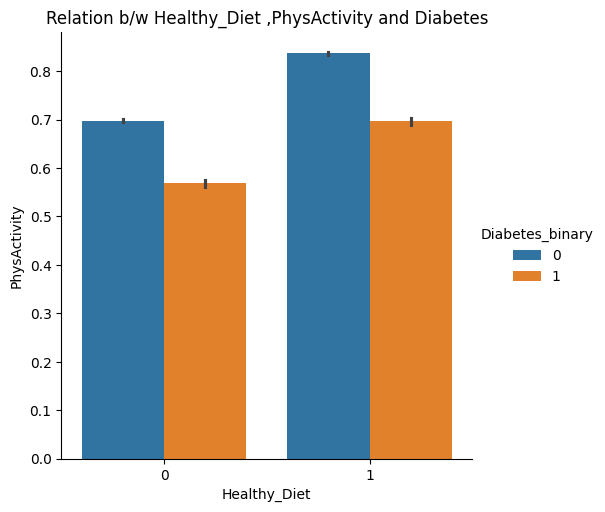

In [ ]:
#Test de la combinaison de healthy_diet et PhysActivity
data.groupby(["Healthy_Diet" , "PhysActivity"])["Diabetes_binary"].value_counts()/data.groupby(["Healthy_Diet" , "PhysActivity"])["Diabetes_binary"].count()
sns.catplot(x="Healthy_Diet" , y ="PhysActivity" , data = data , hue="Diabetes_binary"  , kind="bar"  )
plt.title("Relation b/w Healthy_Diet ,PhysActivity and Diabetes")
plt.xlabel('Healthy_Diet')
plt.ylabel('PhysActivity')
plt.show()

# <h1 style="text-align: center"> <b> Préparation des données</b><br></h1>

In [ ]:
#Suppression des colonnes inutiles
sup_col = ["Age_Group", "CholCheck", "AnyHealthcare", "MentHlth", "Fruits", "Veggies", "BMI_Category"]
train = train.drop(columns=sup_col)
print(train.head())

        HighBP  HighChol        BMI  Smoker  Stroke  HeartDiseaseorAttack  \
31141        0         1  20.693674       1       0                     0   
98230        0         0  28.375985       0       0                     0   
89662        1         1  24.629353       0       0                     0   
208255       0         1  27.246610       0       0                     0   
233415       0         1  23.671678       0       0                     0   

        PhysActivity  HvyAlcoholConsump  NoDocbcCost  GenHlth  ...  DiffWalk  \
31141              1                  0            0        2  ...         0   
98230              1                  0            0        3  ...         0   
89662              1                  0            0        2  ...         0   
208255             1                  0            0        1  ...         0   
233415             1                  0            0        3  ...         1   

        Sex        Age  Education  Income  Healthy_Diet 

In [ ]:
#On recupère les features numériques et catégoriques
num_features = train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = train.select_dtypes(include=["object", "category"]).columns.tolist()

#On applique le preprocessor, un robust scaler pour les features numériques et un one hot encoder pour les features catégoriques
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_features), #RobustScaler car il est moins sensible aux outliers, donne de bon résultats
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

X = preprocessor.fit_transform(train)
y = labels

#Diviser les données 20% pour le test et 80% pour l'entrainement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


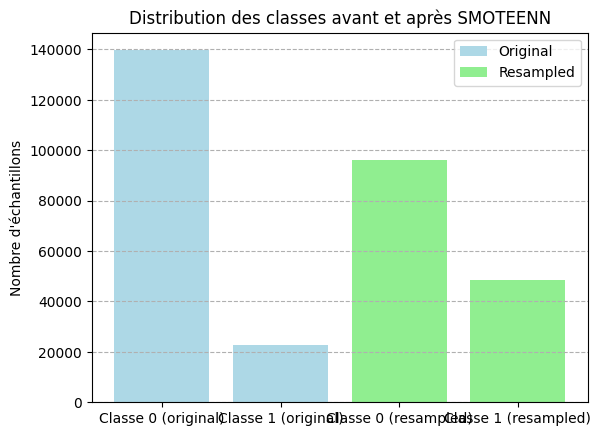

In [ ]:
#Application de SMOTEENN pour gérer les données déséquilibrées et nettoyer les points mal classés
smote_enn = SMOTEENN(sampling_strategy=0.5, random_state=42)  # Atteint 50% de la classe majoritaire
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(type(X_train_resampled))
print(type(y_train_resampled))

#Affichage de la distribution des classes avant et après SMOTEENN
_, counts_original = np.unique(y_train, return_counts=True)
_, counts_resampled = np.unique(y_train_resampled, return_counts=True)

plt.bar(["Classe 0 (original)", "Classe 1 (original)"], counts_original, color="lightblue", label="Original")
plt.bar(["Classe 0 (resampled)", "Classe 1 (resampled)"], counts_resampled, color="lightgreen", label="Resampled")
plt.legend()
plt.title("Distribution des classes avant et après SMOTEENN")
plt.ylabel("Nombre d'échantillons")
plt.grid(axis="y", linestyle="--")
plt.show()

# <h1 style="text-align: center"> <b> Modèle Random Forest</b><br></h1>

In [ ]:

pipeline_rf = RandomForestClassifier(random_state=42)

param_dist_rf = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy','log_loss']
}

### Recherche d'hyperparamètres avec HalvingGridSearchCV

In [ ]:
halving_search_rf = HalvingRandomSearchCV(
    pipeline_rf,
    param_distributions=param_dist_rf,
    cv=5,
    scoring="f1",
    verbose=3,
    random_state=42,
    aggressive_elimination=True,
    min_resources=400,
    n_jobs=-1,

)

with parallel_backend("threading"):
    halving_search_rf.fit(X_train_resampled, np.ravel(y_train_resampled))

NameError: name 'HalvingRandomSearchCV' is not defined

In [ ]:
best_rf= halving_search_rf.best_estimator_
best_rf_params = halving_search_rf.best_params_
y_pred = best_rf.predict(X_test)
print(f"Meilleurs paramètres pour Random Forest : {best_rf_params}")
rf_f1 = f1_score(y_test, y_pred)
print(f"Meilleur Score F1 avec Random Forest : {rf_f1:.4f}")

Meilleurs paramètres pour Random Forest : {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Meilleur Score F1 avec Random Forest : 0.4434


In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89     34919
           1       0.39      0.52      0.44      5670

    accuracy                           0.82     40589
   macro avg       0.65      0.69      0.67     40589
weighted avg       0.84      0.82      0.83     40589

AUC-ROC Score: 0.8081775722530038


### Coube de rappel/précision

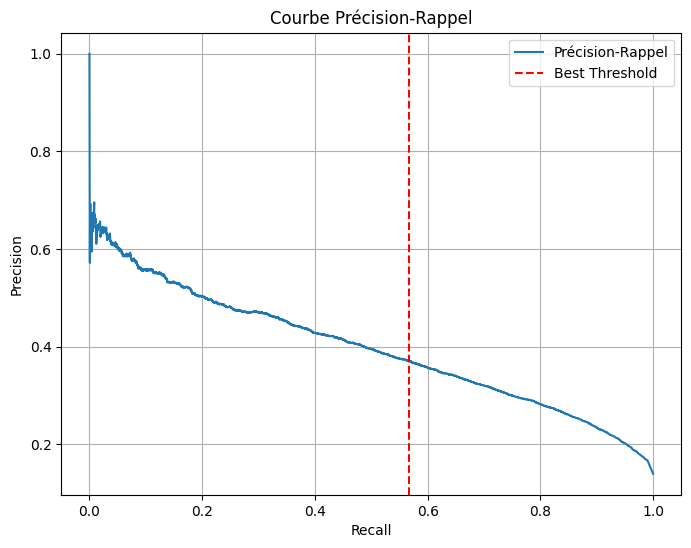

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Précision-Rappel")
plt.axvline(x=recalls[np.argmax(f1_scores)], color="red", linestyle="--", label="Best Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Précision-Rappel")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Calcul du score F1 avec le meilleur seuil
y_pred = (y_pred_proba >= best_threshold).astype(int)
f1_best_threshold = f1_score(y_test, y_pred)
print(f"Score F1 avec le meilleur seuil : {f1_best_threshold:.4f}")

Score F1 avec le meilleur seuil : 0.4488


### Entrainement sur l'ensemble des données avec calibration selon le threshold

In [ ]:
#Création d'un modèle XGBoost avec les meilleurs paramètres, entrainé sur toutes les données
final_rf = RandomForestClassifier(**best_rf_params, random_state=42)
final_rf.fit(X, y)

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(bootstrap=False, criterion='entropy',
                       min_samples_split=5, n_estimators=500, random_state=42)

### Prédiction sur le dataset de test en utilisant le meilleur seuil

In [ ]:
test = pd.read_csv(f"{root}/test.csv", index_col=0)
test = test.drop(columns=sup_col)
test_indices = test.index
test_transformed = preprocessor.transform(test)
preds = (best_rf.predict_proba(test_transformed)[:, 1] > best_threshold).astype(int)

submission = pd.DataFrame({
    "index": test_indices,
    "Diabetes_binary": preds
})
submission.to_csv("submission_rf.csv", index=False)

# <h1 style="text-align: center"> <b> Modèle XGB</b><br></h1>

In [ ]:
ratio_neg_to_pos = y_train_resampled.value_counts()[0] / y_train_resampled.value_counts()[1]
print(f"Ratio négatif/positif : {ratio_neg_to_pos:.2f}")
pipeline_XGB = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    scale_pos_weight=ratio_neg_to_pos
)

param_grid_XGB = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [1, 5, 10]
}

Ratio négatif/positif : 1.98


### Recherche d'hyperparamètres avec HalvingGridSearchCV

In [ ]:
halving_search_XGB = HalvingRandomSearchCV(
    pipeline_XGB,
    param_distributions=param_grid_XGB,
    cv=5,
    scoring="f1",
    verbose=3,
    random_state=42,
    aggressive_elimination=True,
    min_resources=400,
    n_jobs=-1
)

with parallel_backend("threading"):
    halving_search_XGB.fit(X_train_resampled, y_train_resampled)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 400
max_resources_: 144860
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 362
n_resources: 400
Fitting 5 folds for each of 362 candidates, totalling 1810 fits
[CV 5/5] END colsample_bytree=1, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=10, reg_lambda=5, subsample=1;, score=(train=0.812, test=0.792) total time=   0.5s
[CV 2/5] END colsample_bytree=1, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=10, reg_lambda=5, subsample=1;, score=(train=0.802, test=0.735) total time=   0.5s
[CV 3/5] END colsample_bytree=1, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=10, reg_lambda=5, subsample=1;, score=(train=0.779, test=0.800) total time=   0.5s
[CV 4/5] END colsample_bytree=1, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, reg_alpha=10, reg_lambda=5, subsample=1;, score=(train=0.804, test=0.814) total time=  

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV 3/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1;, score=(train=0.922, test=0.841) total time=   0.4s
[CV 1/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1;, score=(train=0.955, test=0.814) total time=   0.4s
[CV 5/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1;, score=(train=0.943, test=0.838) total time=   0.5s
[CV 2/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1;, score=(train=0.923, test=0.743) total time=   0.5s
[CV 4/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1;, score=(train=0.934, test=0.819) total time=   0.5s
[CV 2/5] END colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV 1/5] END colsample_bytree=1, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=10, subsample=1;, score=(train=0.922, test=0.768) total time=   1.1s
[CV 2/5] END colsample_bytree=1, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=10, subsample=1;, score=(train=0.892, test=0.838) total time=   1.1s
[CV 3/5] END colsample_bytree=1, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=10, subsample=1;, score=(train=0.876, test=0.868) total time=   0.9s
[CV 4/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=5, subsample=0.7;, score=(train=0.932, test=0.890) total time=   3.4s
[CV 3/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=5, subsample=0.7;, score=(train=0.923, test=0.883) total time=   3.4s
[CV 2/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5,

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 2
n_resources: 97200
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.7;, score=(train=0.946, test=0.751) total time=  13.7s
[CV 3/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.7;, score=(train=0.906, test=0.922) total time=  13.8s
[CV 2/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.7;, score=(train=0.917, test=0.892) total time=  14.2s
[CV 5/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.7;, score=(train=0.907, test=0.914) total time=  14.3s
[CV 4/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=10, subsampl

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Evaluation du meilleur modèle

In [ ]:
best_XGB = halving_search_XGB.best_estimator_
best_XGB_params = halving_search_XGB.best_params_
y_pred = best_XGB.predict(X_test)
print(f"Meilleurs paramètres pour XGBoost : {best_XGB_params}")
XGB_f1 = f1_score(y_test, y_pred)
print(f"Meilleur Score F1 avec XGBoost : {XGB_f1:.4f}")

Meilleurs paramètres pour XGBoost : {'subsample': 0.7, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.7}
Meilleur Score F1 avec XGBoost : 0.4512


In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
y_pred_proba = best_XGB.predict_proba(X_test)[:, 1]
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87     34919
           1       0.36      0.61      0.45      5670

    accuracy                           0.79     40589
   macro avg       0.64      0.72      0.66     40589
weighted avg       0.85      0.79      0.81     40589

AUC-ROC Score: 0.8170902193249148


### Coube de rappel/précision

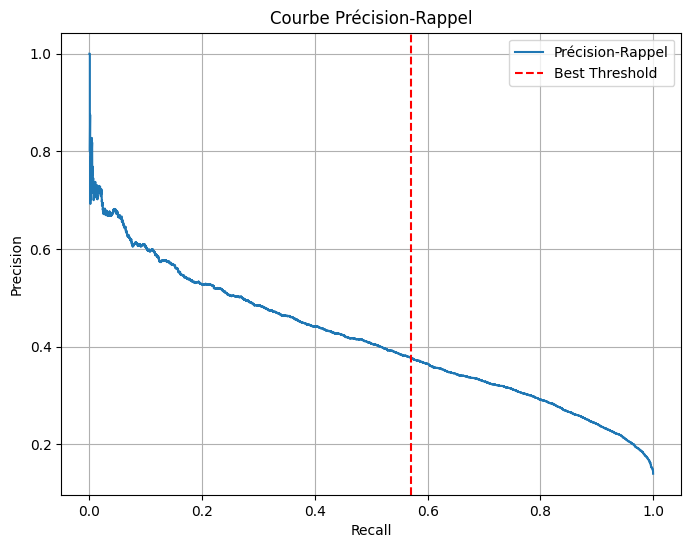

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Précision-Rappel")
plt.axvline(x=recalls[np.argmax(f1_scores)], color="red", linestyle="--", label="Best Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Précision-Rappel")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Calcul du score F1 avec le meilleur seuil
y_pred = (y_pred_proba >= best_threshold).astype(int)
f1_best_threshold = f1_score(y_test, y_pred)
print(f"Score F1 avec le meilleur seuil : {f1_best_threshold:.4f}")

Score F1 avec le meilleur seuil : 0.4548


### Entrainement sur l'ensemble des données avec calibration selon le seuil

In [ ]:
#Création d'un modèle XGBoost avec les meilleurs paramètres, entrainé sur toutes les données
final_XGB = XGBClassifier(**best_XGB_params, use_label_encoder=False, scale_pos_weight=ratio_neg_to_pos, random_state=42)
final_XGB.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Prédiction sur le dataset de test en utilisant le meilleur seuil

In [ ]:
test = pd.read_csv(f"{root}/test.csv", index_col=0)
test = test.drop(columns=sup_col)
test_indices = test.index
test_transformed = preprocessor.transform(test)
preds = (best_XGB.predict_proba(test_transformed)[:, 1] > best_threshold).astype(int)

submission = pd.DataFrame({
    "index": test_indices,
    "Diabetes_binary": preds
})
submission.to_csv("submission_xgb.csv", index=False)

# <h1 style="text-align: center"> <b> Modèle SVM</b><br></h1>


In [ ]:
pipeline_svm = Pipeline([
    ('model', SVC(class_weight="balanced", random_state=42))
])

param_dist_svm = {
    'model__C': [0.01, 0.1, 0.5, 1, 10],
    'model__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'model__kernel': ['rbf', 'poly', 'sigmoid'],
    'model__degree': [2, 3, 4, 5],
    'model__tol': [1e-3, 1e-4, 1e-5],
    'model__shrinking': [True, False]
}

### Recherche d'hyperparamètres avec HalvingGridSearchCV

In [ ]:
#X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns[:X_train_resampled.shape[1]])

halving_search_svm = HalvingRandomSearchCV(
    pipeline_svm,
    param_distributions=param_dist_svm,
    cv=5,
    scoring='f1',
    verbose=3,
    random_state=42,
    aggressive_elimination=True,
    min_resources=400,
    n_jobs=1
)

with parallel_backend("threading"):
    halving_search_svm.fit(X_train_resampled, np.ravel(y_train_resampled))

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 400
max_resources_: 144860
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 362
n_resources: 400
Fitting 5 folds for each of 362 candidates, totalling 1810 fits
[CV 1/5] END model__C=10, model__degree=3, model__gamma=0.1, model__kernel=poly, model__shrinking=True, model__tol=0.0001;, score=(train=0.973, test=0.769) total time=   0.0s
[CV 2/5] END model__C=10, model__degree=3, model__gamma=0.1, model__kernel=poly, model__shrinking=True, model__tol=0.0001;, score=(train=0.983, test=0.585) total time=   0.0s
[CV 3/5] END model__C=10, model__degree=3, model__gamma=0.1, model__kernel=poly, model__shrinking=True, model__tol=0.0001;, score=(train=0.967, test=0.784) total time=   0.0s
[CV 4/5] END model__C=10, model__degree=3, model__gamma=0.1, model__kernel=poly, model__shrinking=True, model__tol=0.0001;, score=(train=0.972, test=0.625) total time=   0.0s
[CV 5/5] END model__C=10, model__d

### Evaluation du meilleur modèle

In [ ]:
best_svm = halving_search_svm.best_estimator_
best_svm_params = halving_search_svm.best_params_
y_pred = best_svm.predict(X_test)
print(f"Meilleurs paramètres pour un SVM : {best_svm_params}")
svm_f1 = f1_score(y_test, y_pred)
print(f"Meilleur Score F1 avec un SVM : {svm_f1:.4f}")


Meilleurs paramètres pour un SVM : {'model__tol': 0.0001, 'model__shrinking': False, 'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__degree': 4, 'model__C': 1}
Meilleur Score F1 avec un SVM : 0.4396


In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
y_pred_proba = best_svm.predict(X_test)
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.73      0.83     34919
           1       0.31      0.74      0.44      5670

    accuracy                           0.74     40589
   macro avg       0.63      0.74      0.63     40589
weighted avg       0.86      0.74      0.77     40589

AUC-ROC Score: 0.7387923464901615


### Coube de rappel/précision

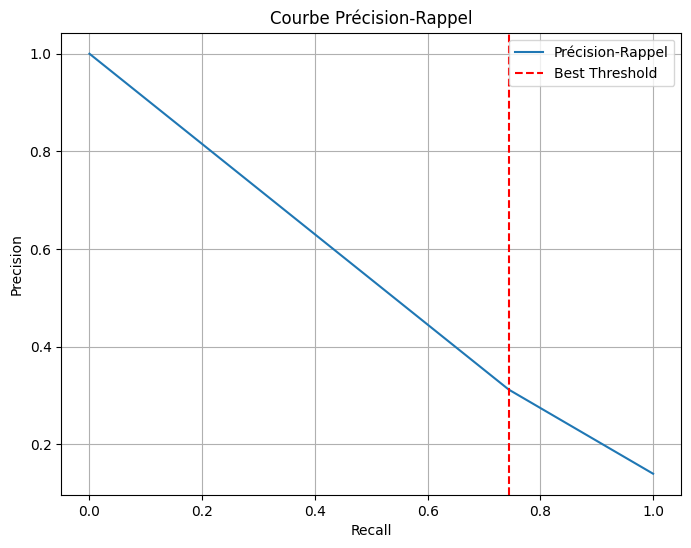

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Précision-Rappel")
plt.axvline(x=recalls[np.argmax(f1_scores)], color="red", linestyle="--", label="Best Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Précision-Rappel")
plt.legend()
plt.grid()
plt.show()

### Calcul du score F1 avec le meilleur seuil

In [ ]:
y_pred = (y_pred_proba >= best_threshold).astype(int)
f1_best_threshold = f1_score(y_test, y_pred)
print(f"Score F1 avec le meilleur seuil : {f1_best_threshold:.4f}")

Score F1 avec le meilleur seuil : 0.4396


### Entrainement sur l'ensemble des données avec calibration selon le seuil

In [ ]:
#Création d'un modèle SVM avec les meilleurs paramètres, entrainé sur toutes les données
svm_params = {key.replace('model__', ''): value for key, value in best_svm_params.items()}
final_svm = SVC(**svm_params, random_state=42)
final_svm.fit(X, y)

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prédiction sur le dataset de test en utilisant le meilleur seuil

In [ ]:
test = pd.read_csv(f"{root}/test.csv", index_col=0)
test = test.drop(columns=sup_col)
test_indices = test.index
test_transformed = preprocessor.transform(test)
preds = (best_XGB.predict_proba(test_transformed)[:, 1] > best_threshold).astype(int)

submission = pd.DataFrame({
    "index": test_indices,
    "Diabetes_binary": preds
})
submission.to_csv("submission_svm.csv", index=False)

# <h1 style="text-align: center"> <b> Modèle MLP</b><br></h1>


In [ ]:
pipeline_MLP = MLPClassifier(
    random_state=42,
    early_stopping=True
)

param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (256,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'batch_size': ['auto', 16, 32, 64],
    'alpha' : 10.0 ** -np.arange(1, 7),
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init' : [1e-4, 1e-3, 1e-2, 1e-1],
    'shuffle' : [True,False],
    'momentum' : [0.3, 0.5, 0.9]
}

In [ ]:
#Initialisation du modèle
mlp = MLPClassifier(random_state=42)

grid_search = HalvingRandomSearchCV(
    estimator=mlp,
    param_distributions=param_grid,
    scoring='f1',
    cv=5,
    min_resources=400,
    verbose=2,
    n_jobs=-1
)

with parallel_backend("threading"):
    grid_search.fit(X_train_resampled, y_train_resampled.values.ravel())

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 400
max_resources_: 144860
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 362
n_resources: 400
Fitting 5 folds for each of 362 candidates, totalling 1810 fits


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   7.9s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   8.0s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   8.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   8.2s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   8.3s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  10.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  10.5s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  10.5s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  10.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  10.7s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  10.8s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  11.0s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  11.2s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  12.6s
[CV] END activation=relu, alpha=1e-06, batch_si

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  16.6s
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   2.3s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   7.6s
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   2.5s
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=1e-05, ba

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   2.9s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.5s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   3.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.6s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   2.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   3.9s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   3.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   3.6s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   3.5s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   3.0s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   3.5s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   3.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  16.4s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  16.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  16.7s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  16.8s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   6.3s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   7.7s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   6.2s
[CV] END activation=relu, alpha=1e-05, batch_siz

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  11.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  11.5s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  11.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  11.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  11.8s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   9.3s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  11.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   5.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  10.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  10.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   5.7s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  10.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  10.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  11.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  11.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  11.7s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   3.4s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   3.7s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   3.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   5.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  11.9s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.01, batch_si

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   1.6s[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   2.7s

[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   6.1s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   5.0s
[CV] END activation=relu, alpha=0.01,

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   5.8s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   5.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   5.7s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   5.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  35.4s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  35.0s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   3.3s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   4.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  36.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   4.8s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  36.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  37.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  13.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  12.9s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  13.1s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  12.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  13.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   8.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   8.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   8.1s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   8.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   8.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   8.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   9.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   9.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   9.5s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   9.6s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   2.0s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   1.8s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   1.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  28.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  32.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  18.0s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  32.9s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   3.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  28.9s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  29.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  32.3s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  32.3s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  29.9s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  18.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  30.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  31.7s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   3.3s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   1.8s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   2.3s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   2.4s
[CV] END activation=tanh, alpha=0.1, batch_size=

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   5.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   5.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.9s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   5.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   3.9s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   3.8s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   3.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  19.1s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  18.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   3.4s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  20.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   3.4s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   5.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   5.6s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   5.7s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   5.7s
[CV] END activation=tanh, alpha=0.001, ba

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=adam; total time=   8.4s
[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   2.2s
[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   2.1s
[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   2.3s
[CV] END activation=relu, alpha=0.01, batch_siz

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=  14.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  27.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  27.4s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=  14.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  27.7s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  27.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  27.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=  14.5s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  13.6s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  13.8s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=  14.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  13.8s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  13.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=  14.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  14.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=   6.8s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=   6.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=   7.0s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=   7.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=   7.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  13.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  13.3s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  13.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  13.0s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  13.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=   7.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  16.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=   7.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=   7.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=   7.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  31.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=   7.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  16.9s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  17.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  16.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  18.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  29.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  14.8s
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  29.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  29.3s
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  29.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  15.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  15.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  16.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  16.4s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  18.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  12.3s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  20.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  12.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=   4.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  12.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=   5.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  24.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=   5.8s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=   5.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=   5.9s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  23.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  14.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  25.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  13.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.7s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=   4.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=   4.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  34.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  34.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  35.1s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  35.1s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  35.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  11.3s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  10.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   6.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  11.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  11.4s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  11.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  21.2s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   6.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   6.2s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   6.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  21.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  21.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  21.3s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   6.2s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   2.3s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   1.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  21.7s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  33.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   2.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  33.8s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  33.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  33.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  34.4s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.3s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.8s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   6.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   4.7s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   4.7s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   7.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   4.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   5.2s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   4.8s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   5.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  17.5s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  20.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  24.5s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  24.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  24.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  14.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  14.2s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  14.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  14.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  14.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  20.9s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  21.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  21.1s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  20.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  20.4s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   8.7s
[CV] END activation=tanh, alpha=0.0001

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   7.6s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   6.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  10.0s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   7.1s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   7.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   7.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   7.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   6.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   6.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   7.1s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   7.1s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  39.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  20.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  21.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  21.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  21.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  21.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   6.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  40.3s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  20.6s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   4.4s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  41.0s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   6.8s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  19.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  40.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  40.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  23.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  23.3s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  23.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   4.8s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   1.5s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   1.6s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   2.8s
[CV] END activation=tanh, alpha=0.01, batch_size=6

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  18.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  18.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  17.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  18.2s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  17.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.3s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.3s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.2s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  17.7s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  18.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  18.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  17.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  18.1s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   9.9s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   9.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  12.9s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  13.2s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  14.0s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  14.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   8.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   8.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   8.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   8.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  26.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  27.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  26.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  27.0s
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  26.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  27.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  27.5s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  27.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  28.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  28.3s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   3.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  15.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   3.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   3.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  16.0s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   3.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   3.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  10.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  11.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  11.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  17.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  17.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  18.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  11.5s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  11.4s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  11.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  15.0s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  15.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  11.3s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  10.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  14.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  14.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  14.7s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   2.1s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.1s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   3.5s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.001, batch_si

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  17.1s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  17.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  17.5s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   3.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  10.7s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   6.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  16.9s
[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  15.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   3.9s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  18.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   4.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   6.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   4.0s
[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  14.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   4.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   4.1s
[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  15.7s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   6.3s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   7.1s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   3.7s
[CV] END activation=relu, alpha=0.001, batch

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.1s
[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.1s
[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   8.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   8.1s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   8.3s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   8.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   8.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  11.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  10.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  10.6s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  10.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  12.0s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   1.6s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  18.1s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   2.0s
[CV] END activation=tanh, alpha=0.1, batch_size=16, 

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  24.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  23.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   5.3s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  23.7s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   5.4s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  23.5s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=1e-06, batch_size=1

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   5.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  13.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  13.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  13.7s[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  13.6s

[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   6.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  31.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  30.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=   4.6s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=   4.5s
[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  10.4s
[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  10.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=   4.6s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   3.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  11.0s
[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  11.0s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   4.4s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   4.0s
[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  11.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  11.6s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  10.3s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  11.9s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   6.5s
[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, batch_siz

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   6.0s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  16.1s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.7s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   5.3s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   8.0s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, batch_size

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   4.7s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   6.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.0s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   4.9s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   6.6s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=  11.0s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   8.8s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   4.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   4.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   4.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   4.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   4.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  11.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  11.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  11.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   8.9s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  11.1s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  11.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  10.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  10.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  11.2s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  10.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  11.1s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  11.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  32.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  32.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  32.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  32.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  33.6s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  27.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  30.2s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   8.2s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  11.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  28.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  11.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  29.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  10.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  31.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  12.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   4.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.0s
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   4.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   4.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.1s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  15.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   5.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   5.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   5.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   5.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   5.2s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  13.3s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   5.2s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   5.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  15.3s
[CV] END activation=tanh, alpha=1e-05, bat

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  18.8s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=adam; total time=   8.4s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  19.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=adam; total time=   6.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  19.2s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=adam; total time=   7.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  19.5s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  19.1s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=adam; total time=   9.1s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=adam; total time=   9.8s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=0.0

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  14.2s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   1.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  14.0s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   3.2s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  13.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  13.8s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  14.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  22.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  21.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  21.5s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  21.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  21.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  10.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  10.4s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  28.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  28.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  28.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  28.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  28.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  19.5s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  20.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  19.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  19.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   6.0s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  20.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   6.3s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   0.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   6.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   2.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   6.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   6.2s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   3.1s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   3.1s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   3.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   3.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  20.0s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   3.2s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   3.1s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   1.6s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001,

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   3.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   3.3s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  19.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  19.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  18.8s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  19.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   3.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   3.5s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   3.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=  27.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=  27.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=  28.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=  28.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=  29.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   5.1s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  23.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   5.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  31.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  31.4s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   5.2s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  32.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  32.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  32.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   9.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   9.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   9.5s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   3.0s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   3.6s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   2.8s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   2.8s
[CV] END activation=relu, alpha=0.01, b

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   5.5s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  28.4s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   5.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  30.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  31.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  30.9s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   7.4s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.8s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   8.1s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   9.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   7.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   8.0s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   8.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   8.0s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   7.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=   4.3s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  10.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=   4.4s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=   4.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=   4.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.3s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  12.1s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.3s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   5.4s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  12.2s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  12.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  12.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  12.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   9.2s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   9.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   9.0s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   9.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   8.9s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   2.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  11.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  11.3s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  11.3s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  11.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  10.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  10.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   9.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   9.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   9.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   9.9s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.0s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   6.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   8.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   8.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   8.2s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  12.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   8.4s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  25.6s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   8.7s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  12.4s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   3.4s
[CV] END activation=relu, alpha=0.01, batch_size=

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  32.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  33.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  33.3s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  33.5s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  16.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  10.7s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  10.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   3.4s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  15.8s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   3.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  16.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   3.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   3.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  15.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  15.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   3.5s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  15.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=  15.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=   7.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=   7.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=   7.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=   7.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=   7.0s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  32.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  27.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  27.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  28.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  36.9s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  37.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  28.3s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  35.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  15.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  29.0s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  15.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  11.7s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  12.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   3.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   3.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   3.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  15.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  16.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  16.0s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  11.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   3.6s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   3.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  11.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  11.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  14.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  14.2s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  14.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  14.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  15.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=  13.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=  13.1s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=  13.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   3.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=  13.2s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   5.7s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=  13.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   6.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  14.1s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  14.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   3.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  14.2s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   3.6s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   3.6s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  12.1s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   2.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  14.7s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   2.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.2s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   2.8s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   2.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  15.4s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  11.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   5.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   5.3s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   5.1s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   5.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  14.2s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   5.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.5s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  15.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  15.6s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  15.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  15.9s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  15.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=   3.4s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=   3.2s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=   3.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  25.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.3s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  26.8s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=   3.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=   3.3s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  25.0s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  26.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  29.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  31.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  31.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  31.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  32.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  33.3s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   9.7s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   8.7s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  10.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  16.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  13.6s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  13.9s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  11.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  14.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  14.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  14.6s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  11.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  16.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  16.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  16.9s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  17.2s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   5.6s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   6.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  17.0s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   7.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   7.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   6.9s
[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   7.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   7.2s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   9.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   7.1s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=  10.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   4.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   4.2s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   4.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   4.3s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   4.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   4.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  17.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  17.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  17.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   4.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  18.1s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   4.2s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   4.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   4.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   4.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  19.0s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   4.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   8.4s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   0.3s
[CV] END activation=relu, alp

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   8.5s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   0.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   8.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   8.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  19.0s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  18.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  19.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  19.1s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   5.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  11.7s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   5.7s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   6.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   4.1s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   5.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   4.6s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  12.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  12.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  12.0s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  12.1s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   4.6s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   9.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   4.4s[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   4.6s

[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   1.6s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=1e-06, ba

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   6.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   6.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   6.9s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   7.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   6.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   8.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  14.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  13.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  13.5s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  13.4s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  13.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  26.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  27.3s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   8.0s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  27.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  28.0s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   8.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  28.1s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   8.3s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   8.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   5.1s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   3.1s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   3.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  11.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   5.8s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  11.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  11.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  11.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  11.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   8.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   8.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   8.5s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   8.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=   8.7s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.1

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  12.3s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  12.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  12.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  12.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  11.9s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   9.9s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  10.6s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   2.9s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   3.6s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  14.5s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   5.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   3.7s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   6.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   3.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   4.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=  12.1s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  17.2s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   3.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   2.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=   3.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   2.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   1.8s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   2.9s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  19.9s
[CV] END activation=tanh, alpha=0.0001, batch_size=6

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   5.9s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   6.0s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   6.0s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   2.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   6.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   6.2s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   2.1s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   3.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  26.8s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   4.9s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   4.3s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   3.6s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   4.7s
[CV] END activation=tanh, alpha=1e-05, 

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   5.3s
[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  27.1s
[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  27.4s
[CV] END activation=tanh, alpha=1e-05, batc

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  12.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  11.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  11.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  11.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  11.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  11.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   9.1s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  11.6s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  14.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  14.7s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  14.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  15.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   8.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   8.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   8.6s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  18.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=   8.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  19.3s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  19.3s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  19.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  19.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   2.2s
[CV] END activation=tanh, alpha=1e-05, b

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  14.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  13.9s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  13.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  13.2s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  13.1s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   0.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   1.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  20.0s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   0.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  20.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  15.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  20.9s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   2.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  19.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  20.5s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   2.8s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   3.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  14.5s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  15.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   3.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  15.1s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   3.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  15.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   7.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   7.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   7.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   8.0s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   6.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   6.7s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   7.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   8.0s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   6.7s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   0.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   7.6s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   1.6s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=adam; total time=   1.8s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  29.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   5.1s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  29.7s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  29.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  30.1s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   1.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  30.8s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   1.6s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   1.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   6.5s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   3.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   6.6s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   6.9s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   3.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  12.7s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  13.0s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  12.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  13.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  13.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  13.3s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  13.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  13.2s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  12.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  13.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  17.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  16.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  17.4s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  17.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  17.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  15.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  14.0s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  14.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  14.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  15.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  31.5s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  25.9s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  29.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  30.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  30.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  23.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  31.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  31.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  31.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  33.1s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  23.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  32.6s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   9.4s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  22.9s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  22.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  23.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   4.3s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   4.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   4.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   4.3s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   4.5s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=   4.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   4.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   4.2s
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   4.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   4.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  31.5s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  15.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   5.0s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  15.8s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  25.1s
[CV] END activation=relu, alpha=0.001, batch

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   9.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  30.6s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  19.2s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  27.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   9.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  29.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   8.1s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   8.5s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   8.0s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  16.4s
[CV] END activation=tanh, alpha=0.1, batc

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  18.2s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  18.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  18.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  18.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  19.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  11.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  26.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  26.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  27.3s
[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  12.7s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  12.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  27.3s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  13.1s
[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=sgd; total time=  27.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  13.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=   4.6s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=   4.7s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=   4.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=   4.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   4.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  32.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  33.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  33.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   4.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  33.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   4.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  34.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   4.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  18.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  15.0s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  14.4s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  18.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  15.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  15.3s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  18.4s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  15.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  17.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  18.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   7.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   7.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   7.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   8.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   8.2s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   4.6s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   4.3s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   4.1s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   3.3s
[CV] END activation=tanh, alpha=1e-06, batch_si

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  14.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  13.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  14.1s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  14.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  14.6s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  16.1s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=   1.8s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   3.2s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   7.1s
[CV] END activation=tanh, alpha=1e-05, batch_siz

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  21.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  21.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  21.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  21.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   8.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   9.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  11.3s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  10.9s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.7s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   5.7s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   4.3s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   2.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  14.2s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   3.7s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   2.2s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   2.9s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=0.001

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  14.1s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  15.2s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  13.6s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   3.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  13.9s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  14.8s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   7.5s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   7.9s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   6.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   4.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   4.4s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   4.4s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   8.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   4.3s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  32.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  32.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  32.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  33.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  33.4s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   8.0s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   8.2s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   6.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   5.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.9s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   7.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  12.3s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  13.5s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   6.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.6s
[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   4.8s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  15.5s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   2.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   7.1s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   6.9s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   7.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   6.8s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=   6.8s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   3.1s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   2.3s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   2.7s
[CV] END activation=tanh, alpha=0.01, batch_si

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   2.9s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   3.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  22.7s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  22.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  22.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  23.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  16.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  16.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  16.8s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  16.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  17.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   6.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   7.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   7.1s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   7.0s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=   6.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  14.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  15.2s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  15.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  12.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  15.2s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  15.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.8s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  14.5s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  14.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  14.1s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  14.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.9s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  20.5s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   7.1s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  11.3s
[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  11.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  11.3s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   8.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  19.8s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   8.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  20.0s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=   9.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  19.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  20.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  10.7s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  12.6s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   2.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.8s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.0s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   7.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   8.1s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   7.5s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=   7.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   7.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   7.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=   7.5s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   3.0s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   2.4s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   2.8s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=   4.3s
[CV] END activation=relu, alpha=1e-06, batc

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  30.2s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  13.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  16.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  16.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  16.4s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  16.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  28.9s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  28.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  29.4s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   3.0s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   3.5s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   3.4s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   5.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  25.3s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  25.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   4.7s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  25.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  25.7s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  25.7s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   4.8s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   5.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   5.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   5.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   5.2s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  17.1s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  34.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  12.9s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  13.0s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  12.8s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  12.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  12.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  13.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  14.2s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  14.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  14.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  14.0s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   3.5s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   2.6s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   1.7s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=adam; total time=   1.3s
[CV] END activation=relu, alpha=1e-05, 

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  17.8s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   3.0s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   2.3s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   1.9s
[CV] END activation=relu, alph

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  18.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  39.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  39.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  16.3s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  16.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  17.1s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  16.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  17.3s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  17.4s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   7.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  16.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   7.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  16.7s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   7.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   4.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   7.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=   7.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   4.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   4.8s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  42.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   5.0s
[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=   4.9s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  12.7s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  14.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  14.8s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  15.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  15.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  14.5s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  14.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  13.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  13.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  14.5s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  15.3s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=1e-05, 

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  22.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  21.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  21.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  22.2s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  21.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   8.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   7.8s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   8.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   8.0s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  11.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   8.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   5.1s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   4.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   5.1s
[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   4.9s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  14.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=   4.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  15.2s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   4.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  18.1s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   3.9s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  18.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  17.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  17.9s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  18.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  16.4s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  13.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  16.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  13.7s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  13.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  13.8s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  16.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=  13.2s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  16.5s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   5.1s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   5.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  16.4s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   7.5s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   0.6s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.1, batch_s

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  13.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  13.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  14.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  13.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  14.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  13.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  14.0s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  13.8s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=   7.7s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  13.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  16.6s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  16.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  14.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  16.7s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  17.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  17.3s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=   6.8s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=   9.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.4s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=  14.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  12.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  12.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  12.8s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  12.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  12.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  12.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  12.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  12.2s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=  16.0s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  12.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  12.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   7.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   7.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   7.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   7.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   7.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  10.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  18.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  18.1s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  17.8s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  17.8s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  12.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  18.9s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  22.5s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  22.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  24.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  24.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   8.7s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=sgd; total time=  24.7s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   6.4s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  13.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   6.1s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  12.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   9.6s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   9.2s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   6.1s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  13.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   9.8s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   5.5s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=sgd; total time=  13.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  10.1s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   4.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   3.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   5.4s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   5.4s
[CV] END activation=relu, alpha=1e

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=   5.5s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=   5.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=   6.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=   5.8s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=   5.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=   5.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  11.8s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  11.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  12.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  12.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  12.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  11.7s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  12.0s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  12.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  11.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  12.0s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=adam; total time=   2.9s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=adam; total time=   4.7s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=adam; total time=   4.6s
[CV] END activation=relu, alpha=0.0001, batc

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=  27.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=  27.8s
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=sgd; total time=  28.0s
[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time=   0.3s
[CV] END activation=relu,

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=adam; total time=   9.3s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   2.5s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  18.1s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  16.2s
[CV] END activation=tanh, alpha=0.01, batc

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   2.4s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   3.4s
[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  29.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  31.1s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   4.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   5.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   5.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   5.4s
[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   5.4s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   8.1s
[CV] END activation=tanh, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=   5.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=   6.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  21.2s
[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=   6.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=   6.7s
[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=   6.8s
[CV] END activation=tanh, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=   6.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  23.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  22.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  23.1s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  23.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  20.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  20.3s
[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  19.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  21.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=sgd; total time=  20.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  12.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  12.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  12.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  12.5s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   6.1s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  11.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  12.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   8.8s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  10.1s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  10.3s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  20.3s
[CV] END activation=tanh, alpha=0.001, batch_s

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=   7.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=   7.3s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  29.1s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  25.0s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   3.3s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   2.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=   7.3s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   2.1s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   3.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=   7.7s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=  16.0s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   3.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=   7.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=  15.8s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=  14.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=  16.7s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   6.4s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   6.8s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   7.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=  16.6s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  31.7s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   9.6s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=   7.1s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  10.3s
[CV] END activation=relu, alpha=0.001, batch_size=

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  14.6s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  14.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  14.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  14.7s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  14.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  24.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  24.9s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  21.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  25.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  25.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  14.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  13.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  14.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  13.8s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  14.2s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   1.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  10.4s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   6.6s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  10.7s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   2.6s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   1.5s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=   2.0s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   7.2s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_la

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   7.2s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=   9.7s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=  34.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.5s
[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.6s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=  35.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=  34.8s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=adam; total time=  10.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=  34.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   4.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=adam; total time=  35.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=   3.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   5.2s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   5.0s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   4.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   4.8s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=   4.8s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  11.4s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  11.6s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  11.3s
[CV] END activation=relu, alpha=0.0001, ba

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=False, solver=sgd; total time=  10.2s
----------
iter: 1
n_candidates: 121
n_resources: 1200
Fitting 5 folds for each of 121 candidates, totalling 605 fits
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  29.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  31.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  31.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  33.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  33.7s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  13.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.0min
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  14.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   8.4s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   8.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   8.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   8.5s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  13.6s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  15.5s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  15.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=   7.9s
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   4.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   4.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time= 1.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time= 1.4min
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   5.3s
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time= 1.5min
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   4.6s
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=adam; total time=   4.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.1min
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  28.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  46.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  46.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  46.4s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  33.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  47.0s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  34.1s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  33.2s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  33.5s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  28.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  47.2s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  34.3s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=adam; total time=  40.6s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  37.1s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=adam; total time=  35.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  19.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  19.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  19.9s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  19.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  19.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  46.5s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  24.6s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  24.7s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  25.7s
[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  34.5s
[CV] END activation=relu, alpha=0.0001, bat

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  46.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  46.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  47.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  46.7s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  28.9s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  30.5s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  27.0s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  34.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  52.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  44.6s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  27.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  46.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  46.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  48.2s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  44.4s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  29.8s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  27.4s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  33.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  45.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  41.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  40.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  42.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  44.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  42.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  47.3s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   8.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  47.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  50.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  48.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  49.3s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   6.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   7.8s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   8.3s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=   7.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  41.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  40.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  42.7s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  11.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  11.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  11.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  44.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  12.1s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  12.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  45.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time= 1.3min
[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time= 1.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time= 1.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=sgd; total time= 1.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  48.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  49.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  30.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  49.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  50.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  30.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  50.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  30.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  29.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  30.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  52.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  50.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  53.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  52.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  51.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  50.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  51.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  50.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  48.9s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  49.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  47.2s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  48.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  49.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  48.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  50.0s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  49.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  31.1s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  30.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  30.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  31.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  52.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  45.6s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  30.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  51.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  52.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  54.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  46.5s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  47.2s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  12.0s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  47.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  38.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  38.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  47.2s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  13.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  12.8s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  12.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  13.0s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  34.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  35.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  36.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  35.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  35.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  33.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  34.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  34.0s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  14.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  34.3s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 1.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  34.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  34.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  34.4s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  18.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  34.8s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  14.3s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 1.2min
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 1.2min
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  15.4s
[CV] END activation=relu, alpha=0.001, batch_

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  10.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  11.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  11.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 1.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  11.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  11.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 1.5min
[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  10.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 1.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  10.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  10.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  10.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  10.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  46.8s
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  46.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  46.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  46.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=sgd; total time=  45.4s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  21.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  28.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  28.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  27.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  28.1s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  23.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  27.9s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  24.9s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  20.6s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  20.0s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  20.4s
[CV] END activation=tanh, alpha=0.01, 

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  11.2s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  45.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  11.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  11.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  11.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  11.3s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  44.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time= 1.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  49.2s
[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time= 1.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  47.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time= 1.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  40.3s
[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  49.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  48.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  46.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 1.5min
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  11.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 1.6min
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  18.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 1.5min
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  11.6s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  12.4s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  15.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  38.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  38.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  38.9s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  39.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  41.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  42.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  41.5s
[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  41.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  43.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  19.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  19.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  19.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  35.6s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  19.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  19.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  35.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  36.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  34.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time=  34.3s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   5.3s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  32.3s
[CV] END activation=relu, alpha=0.01, batch_size=

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  42.6s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  33.0s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  33.3s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  37.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  43.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  43.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  44.4s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  30.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  44.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  45.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  23.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  24.5s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  14.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  48.7s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  24.8s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  14.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  26.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  12.3s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  26.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  12.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  12.6s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  20.5s
[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  12.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  12.8s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  18.0s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  18.8s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  49.4s
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time=  50.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 1.3min
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  51.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  50.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  50.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  49.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  52.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  51.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  50.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  47.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  55.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  49.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  10.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time= 1.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time= 1.2min
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  34.8s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  10.5s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  29.3s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  32.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  11.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  51.8s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  36.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  51.7s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  20.0s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  20.9s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  18.1s
[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  18.5s
[CV] END activation=relu, alpha=1e-06, b

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  52.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  53.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  50.3s
[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  51.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  56.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  35.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  36.3s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  36.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  36.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  36.6s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  22.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  36.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  35.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  36.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  36.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  37.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  11.2s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  11.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  11.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  23.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  10.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1, momentum=0.9, shuffle=True, solver=sgd; total time=  11.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  23.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  24.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  24.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  13.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  13.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  13.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  13.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  13.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  29.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  28.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  27.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  29.2s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  27.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 1.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 1.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 1.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 1.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 1.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  47.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  46.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  47.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  46.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  46.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  46.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  46.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  49.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  46.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  50.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  28.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  28.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  28.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  28.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time=  28.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  27.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 1.4min
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 1.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  28.2s
[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 1.5min
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  27.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  21.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  28.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  28.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  32.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  32.8s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  32.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 1.5min
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  30.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  29.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  28.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  29.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  28.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  29.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 1.5min
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=   9.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  26.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  48.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  47.4s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  25.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  26.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  27.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  48.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  26.8s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=   8.7s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=  17.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   8.5s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=  10.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  42.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   8.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   8.6s
[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   9.1s
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=  12.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=   8.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  47.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  43.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  44.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  42.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  43.9s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  15.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=adam; total time=  45.7s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  16.2s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  17.2s
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  18.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  22.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  34.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  35.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  35.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  34.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=  34.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  35.0s
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  34.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  34.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  35.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  34.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  55.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  54.3s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  54.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  54.3s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  55.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  53.8s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  30.9s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  32.0s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  37.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  46.3s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  41.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  34.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  44.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  45.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time=  46.1s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=adam; total time=  45.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  49.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  48.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  49.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  50.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  49.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  35.5s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  28.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  36.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  38.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=False, solver=sgd; total time=  37.6s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  31.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  30.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  30.2s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  24.3s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  35.2s
[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  25.0s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  36.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  33.2s
[CV] END activation=tanh, alpha=0.1, batch_size=32, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=adam; total time=  49.5s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.01, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, batch_si

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  27.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  27.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  25.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  28.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  25.8s
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  27.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time=  27.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  47.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  25.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  25.5s
[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  47.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  46.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  10.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  10.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  25.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  48.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  49.8s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  23.1s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=  15.1s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=  38.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  40.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  41.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  41.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  41.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  40.7s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=  17.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  41.2s
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  41.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  40.8s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=  29.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  41.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  41.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  14.1s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=  14.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  14.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  13.7s
[CV] END activation=tanh, alpha=0.1, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=adam; total time=  21.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  14.0s
[CV] END activation=tanh, alpha=0.0001, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  13.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  13.7s
[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  13.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  13.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  13.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=  13.7s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  28.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  28.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  28.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  28.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  29.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  38.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  38.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  38.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  38.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time=  39.0s
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  39.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  39.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  39.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  39.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  35.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  35.6s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  37.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  35.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  35.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=  31.8s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=  15.0s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=  16.1s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  33.3s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=  18.9s
[CV] END activation=relu, alpha=0.1, batch_size=16, hi

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  47.0s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=adam; total time=  25.1s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  42.4s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  48.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  47.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  47.5s
[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  47.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  29.9s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time=  57.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  31.8s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  32.2s
[CV] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=adam; total time= 1.0min
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  32.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  32.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  32.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  32.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  31.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  31.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time=  31.7s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  31.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  31.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  31.3s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  31.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=False, solver=adam; total time=  30.0s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  13.7s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  39.9s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  23.7s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  24.3s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hi

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  37.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  40.4s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  40.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  36.0s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  35.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  38.5s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  29.6s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time=  38.5s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  33.2s
[CV] END activation=tanh, alpha=0.001, batch_size=32, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.5, shuffle=True, solver=sgd; total time=  32.7s
----------
iter: 2
n_candidates: 41
n_resources: 3600
Fitting

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  39.3s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  39.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  39.5s
[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  39.5s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  40.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  37.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.3min
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.3min
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time= 1.5min
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  40.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  39.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  40.2s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  39.9s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  36.5s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  42.1s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time= 2.4min
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  30.4s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  32.1s
[CV] END activation=tanh, alpha=0.01, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time=  42.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time= 1.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time= 2.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time= 1.6min
[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time= 2.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time= 2.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.9, shuffle=True, solver=sgd; total time= 2.4min
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.9, shuffle=True, solver=sgd; total time= 1.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time= 1.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time= 1.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time= 1.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time= 1.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=True, solver=sgd; total time= 1.9min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time= 1.5min
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time= 1.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time= 1.5min
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001, momentum=0.9, shuffle=False, solver=sgd; total time= 1.5min
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 2.0min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time= 1.2min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time=  58.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time= 1.4min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 2.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 2.5min
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 4.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 2.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 1.8min
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 4.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 2.0min
[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 4.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 4.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 2.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 2.6min
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 2.1min
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 2.0min
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 2.1min
[CV] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 2.1min
[CV] END activation=relu, alpha=0.1, b

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.9min
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 2.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 3.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 2.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 3.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 3.8min
[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 3.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 5.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 5.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 5.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 5.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=16, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=False, solver=sgd; total time= 3.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 5.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 1.8min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 1.8min
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time=  42.6s
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.1, batch_size=64,

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time= 1.6min
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 1.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time= 1.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time= 1.7min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time= 1.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time= 1.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time= 1.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.3, shuffle=False, solver=sgd; total time= 1.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.1min
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.1min
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 2.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 2.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 2.2min
[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 2.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 2.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 2.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 2.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 2.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 2.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 2.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 2.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 2.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 2.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  28.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  28.7s
[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  28.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  29.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 2.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.1, momentum=0.3, shuffle=False, solver=sgd; total time=  29.6s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 2.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  28.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  28.9s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.3, shuffle=True, solver=sgd; total time= 1.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  28.8s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  27.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=auto, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  26.9s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  26.4s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  27.9s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  24.7s
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1, momentum=0.9, shuffle=False, solver=sgd; total time=  25.9s
[CV] END activation=relu, alpha=0.001, batch_

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=32, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 4.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 4.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 4.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 4.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 4.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 4.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 4.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 2.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 4.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 4.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.3, shuffle=False, solver=adam; total time= 4.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 4.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 4.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 4.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  30.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  31.3s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 4.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  31.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  29.7s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=16, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 4.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=auto, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01, momentum=0.9, shuffle=False, solver=sgd; total time=  25.4s


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 1.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 1.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 1.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 1.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time=  58.7s
[CV] END activation=relu, alpha=1e-05, batch_size=64, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 1.0min
----------
iter: 3
n_candidates: 14
n_resources: 10800
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.0min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 3.1min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 4.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 4.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 4.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 4.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 4.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 5.3min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time= 4.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 5.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 5.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time= 5.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 5.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time= 5.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 5.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time= 5.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time= 5.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 5.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=10.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 9.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=10.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=10.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=11.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 6.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 6.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 6.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 6.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 6.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 6.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 6.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 6.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=True, solver=adam; total time= 6.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 6.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 6.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 6.9min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time= 1.6min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time= 2.4min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time= 2.3min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(64,), learning_rate=constant, learning_rate_init=0.001, momentum=0.5, shuffle=True, solver=adam; total time= 2.4min
[CV] END activation=tanh, alpha=0.1, batch_size=64, h

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 5.6min
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 3.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 6.4min
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 2.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 5.6min
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 3.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 6.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 5.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 5.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time= 5.2min
[CV] END activation=tanh, alpha=0.1, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001, momentum=0.3, shuffle=True, solver=adam; total time= 3.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 5.1min
[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 5.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 5.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 4.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=32, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time= 6.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 4.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 4.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 4.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 4.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-05, batch_size=32, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.9, shuffle=True, solver=adam; total time= 4.3min
----------
iter: 4
n_candidates: 5
n_resources: 32400
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=10.1min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=10.5min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.3, shuffle=True, solver=adam; total time=12.3min
[CV] END activation=relu, alpha=0.1, batch_size=64, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=16.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=16.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=16.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=16.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, batch_size=64, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01, momentum=0.5, shuffle=True, solver=sgd; total time=16.5min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=17.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=17.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=17.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=17.9min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=18.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=12.0min
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=15.2min
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 9.3min
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=25.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 9.8min
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=13.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 9.8min
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=16.1min
[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time= 9.8min
[CV] END activation=relu, alpha=0.01, batch_size=32, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=14.0min
----------
iter: 5
n_candidates: 2
n_resources: 97200
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=38.0min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=39.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=39.3min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=39.4min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=39.6min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=39.7min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001, momentum=0.5, shuffle=False, solver=adam; total time=39.8min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=40.1min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=40.2min


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=64, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001, momentum=0.9, shuffle=False, solver=adam; total time=40.7min


### Evaluation du meilleur modèle

In [ ]:
#Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)

#Évaluation du modèle avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))

Meilleurs paramètres trouvés : {'solver': 'adam', 'shuffle': False, 'momentum': 0.5, 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'hidden_layer_sizes': (256,), 'batch_size': 64, 'alpha': 1e-06, 'activation': 'relu'}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.11      0.20     34919
           1       0.15      1.00      0.27      5670

    accuracy                           0.24     40589
   macro avg       0.58      0.56      0.24     40589
weighted avg       0.88      0.24      0.21     40589

AUC-ROC Score: 0.806821415325859


In [ ]:
#Calcul du score F1
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

F1 Score: 0.26769827749384817


### Coube de rappel/précision

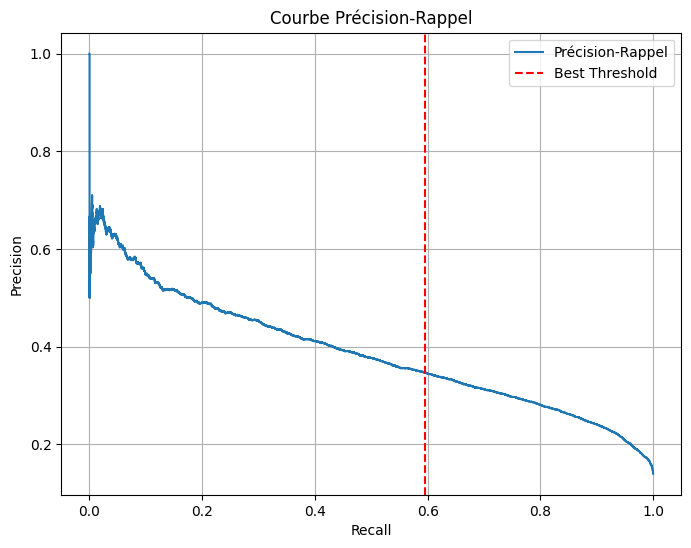

In [ ]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Précision-Rappel")
plt.axvline(x=recalls[np.argmax(f1_scores)], color="red", linestyle="--", label="Best Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Précision-Rappel")
plt.legend()
plt.grid()
plt.show()

###Calcul du score F1 avec le meilleur seuil

In [ ]:
y_pred = (y_pred_proba >= best_threshold).astype(int)
f1_best_threshold = f1_score(y_test, y_pred)
print(f"Score F1 avec le meilleur seuil : {f1_best_threshold:.4f}")

Score F1 avec le meilleur seuil : 0.4387


### Entrainement sur l'ensemble des données avec calibration selon le seuil

In [ ]:
final_mlp = MLPClassifier(**grid_search.best_params_, random_state=42)
final_mlp.fit(X, y)

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(alpha=1e-06, batch_size=64, hidden_layer_sizes=(256,),
              learning_rate_init=0.0001, momentum=0.5, random_state=42,
              shuffle=False)

### Prédiction sur le dataset de test en utilisant le meilleur seuil

In [ ]:
test = pd.read_csv(f"{root}/test.csv", index_col=0)
test = test.drop(columns=sup_col)
test_indices = test.index
test_transformed = preprocessor.transform(test)
preds = (final_mlp.predict_proba(test_transformed)[:, 1] > best_threshold).astype(int)

submission = pd.DataFrame({
    "index": test_indices,
    "Diabetes_binary": preds
})
submission.to_csv("submission_mlp.csv", index=False)